### Cargo packages e inicializo

In [2]:
# %% Preparo todo, cargo packages
import sys
sys.path.insert(1, '../')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import fcnAFIL
import lesion_classifiers as lc
import time
import SimpleITK as sitk
from scipy.optimize import curve_fit
from scipy.stats import norm

            

if os.environ['COMPUTERNAME']=='DIEGO-DESKTOP':
    datadir = 'E:/Entelai/DATA/Dataset 6x24'
    codedir = 'E:/REPOS/entelai_threshold_finetuning/'
else:
    datadir = 'C:/Entelai/DATA/Dataset_6x4_24'
    codedir = 'C:/REPOS/entelai_threshold_finetuning/'
    
outdatadir = os.path.join(datadir, 'out')

### Armo PARES y guardo file (una vez)

In [ ]:
# %% Armo y proceso pares y guardo file
param = {"thres":np.nan, "slope":np.nan, "growtype":"largesmall_01p", \
    'fcn_classify_lesions':lc.classify_lesion_largesmall_01p_new10, \
        'condname':'largesmall_01p_new10'}

ST = fcnAFIL.build_structure_ST_6x4(datadir)
PAR = fcnAFIL.build_pairs_of_studies_6x4(ST)    

# PAR = [par for par in PAR if par['samereso']==True and par['samesubj']==True]        
PAR = [par for par in PAR if par['samesubj']==True]        

t = time.time()
for i, par in enumerate(PAR):
    par = fcnAFIL.full_process_pair(par=par, outdatadir=outdatadir, param=param)

    # Delete some memory-consuming keys, to fit in memory
    if 'index' in par:
        del par['index']    
    for ind, study in enumerate(par['studies']):
        for keyremove in ['img', 'array', 'labels', 'volumen',
                            'lblchanges', 'relabeled']: # for back compatibility
            if keyremove in par['studies'][ind]:
                del par['studies'][ind][keyremove]

    PAR[i] = par

    t1 = time.time() - t
    print("%d/%d %s %2.2fs %s" % (i,len(PAR),par['studiesname'], t1, param['condname']))
print('Listo')
np.savez_compressed(os.path.join(datadir,'PARES_6x4.npz'), PAR=PAR)
# loaded = np.load(os.path.join(datadir,'PARES_6x4.npz'), allow_pickle=True)
# loaded.files
# PAR = list(loaded['PAR'])

### Cargo file generado

In [3]:
# %% cargo file
loaded = np.load(os.path.join(datadir,'PARES_6x4.npz'), allow_pickle=True)
loaded.files
PAR = list(loaded['PAR'])
print(len(PAR))

36


### Genero planilla unificada

In [5]:
subject = []
samereso = []
id = []
v1 = []
v2 = []
for par in PAR:
    lvtm = par['LVTM']
    for row in lvtm:
        subject.append(par['subject'])
        samereso.append(par['samereso'])
        id.append(row[0])
        v1.append(row[1])
        v2.append(row[2])

df = pd.DataFrame(list(zip(subject,samereso,id,v1,v2)), columns=['subject','samereso','id','v1','v2'])

fcns = [lc._classify_lesions_4tau_samereso, lc._classify_lesions_6tau_samereso ,lc._classify_lesions_6tau_diffreso]
fcnnames = ['cat 4tau','cat 6tau samereso','cat 6tau diffreso']
for fcn,name in zip(fcns,fcnnames):
    index = fcn(df.v1,df.v2)
    categ = index['grow']*1+index['stable']*2+index['new']*3
    categs = ('error', 'grow', 'stable', 'new')    
    for i in range(len(categ)):
        categ[i]=categs[categ[i]]

    df[name] = categ
df.to_excel(os.path.join(outdatadir,'dataset_6x4_all_lesions.xlsx'),index=False)
print('Listo')

C:\Users\Diego\AppData\Local\Temp\ipykernel_19648\234076563.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'grow' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  categ[i]=categs[categ[i]]
C:\Users\Diego\AppData\Local\Temp\ipykernel_19648\234076563.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'grow' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  categ[i]=categs[categ[i]]
C:\Users\Diego\AppData\Local\Temp\ipykernel_19648\234076563.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'grow' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  categ[i]=categs[categ[i]]


Listo


### Defino funciones de ploteo

In [43]:
# %% Defino funciones de ploteo

def df_extract_vp_dvp(PAR,samereso):
    vol1 = np.array([])
    vol2 = np.array([])
    sid = np.array([])
    samereso = np.array([])
    for par in PAR:
        if 'LVTM' not in par:
            continue
        # if 'samereso' in par:
        #     if par['samereso'] not in samereso:
        #         continue  
        item = par['LVTM']
        vol1 = np.append(vol1,item[:,1])
        vol2 = np.append(vol2,item[:,2])
        ndata = len(item[:,2])
        sid = np.append(sid,np.repeat(par['studies'][0]['subject'],ndata))
        samereso = np.append(samereso,np.repeat(par['samereso'],ndata))

    df = pd.DataFrame([vol1,vol2,sid,samereso],index=['vol1','vol2','sid','samereso']).T
   
    df['vp'] = (df['vol2']+df['vol1'])/2.
    df['dvp'] = (df['vol2']-df['vol1'])/df['vp']*100.
    df = df.sort_values('vp')

    df = df[(df.vol1>0) & (df.vol2>0)]
    
    return df

def plotv1v2(v1,v2,maxx):
    plt.plot(v1,v2,'.')
    plt.axis('square')
    plt.xlim([0,maxx])
    plt.ylim([0,maxx])
    plt.grid(True)
    x = np.linspace (0,maxx,1000)
    plt.plot(x, x, 'k--',linewidth=0.5)
    plt.xlabel('V$_1$ [mm$^3$]')
    plt.ylabel('V$_2$ [mm$^3$]')

def plotdvpdv(v1,v2):
    vp = (v2+v1)/2.
    dvp = (v2-v1)/vp*100
    plt.plot(dvp,vp,'.')
    plt.xlim([-200,200])
    plt.grid(True)
    plt.xlabel("% change volume")
    plt.ylabel("Mean volume [mm$^3$]")

    
def plot_v1v2_dvpdv(v1,v2,samereso):
    v1 = np.array(v1)
    v2 = np.array(v2)
    maxx = max(max(v1),max(v2))*1.05
    
    plt.figure()
    h=dict()
    h['fig'] = plt.gcf()
    h['fig'].set_size_inches(7, 7)    
    
    h['h1'] = plt.subplot(221)
    # plotv1v2(v1,v2,maxx)
    plotv1v2(v1[samereso==1],v2[samereso==1],maxx)
    plotv1v2(v1[samereso==0],v2[samereso==0],maxx)
    

    h['h2'] = plt.subplot(222)
    # plotv1v2(v1,v2,maxx*1.3)
    plotv1v2(v1[samereso==1],v2[samereso==1],maxx*1.3)
    plotv1v2(v1[samereso==0],v2[samereso==0],maxx*1.3)   
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([.7,maxx*1.3])
    plt.ylim([.7,maxx*1.3])    

    h['h3'] = plt.subplot(223)
    # plotdvpdv(v1,v2)
    plotdvpdv(v1[samereso==1],v2[samereso==1])
    plotdvpdv(v1[samereso==0],v2[samereso==0])

    h['h4'] = plt.subplot(224)
    plotdvpdv(v1[samereso==1],v2[samereso==1])
    plotdvpdv(v1[samereso==0],v2[samereso==0])    
    # plotdvpdv(v1,v2)
    plt.yscale('log')
    
    plt.tight_layout()
    
    return h

def plot_v1v2_4escalas(v1,v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    maxx = max(max(v1),max(v2))*1.05
    
    plt.figure()
    h=dict()
    h['fig'] = plt.gcf()
    h['fig'].set_size_inches(7, 7)    
    
    h['h1'] = plt.subplot(221)
    plotv1v2(v1,v2,maxx)
    plt.xlim([0, 100])
    plt.ylim([0, 100])

    h['h2'] = plt.subplot(222)
    plotv1v2(v1,v2,maxx)
    plt.xlim([0, 250])
    plt.ylim([0, 250])

    h['h3'] = plt.subplot(223)
    plotv1v2(v1,v2,maxx)
    plt.xlim([0, 1000])
    plt.ylim([0, 1000])
    
    h['h4'] = plt.subplot(224)
    plotv1v2(v1,v2,maxx)
    
    plt.tight_layout()
    return h

def AgregoCte(h1s,h2s):
    for ax in h1s:
        plt.sca(h[ax])
        maxx = max(plt.ylim())
        x = np.linspace (0,maxx,1000)
        x = np.logspace(-1,5,100)
        plt.plot(x, x + 48, 'r',label="cte=48")
        
    for ax in h2s:
        plt.sca(h[ax])
        ylim = plt.ylim()
        x = np.logspace(-1,5,100)
        plt.plot(100*1/((x/48)+.5),x,'r',linewidth=2)
        plt.ylim(ylim)    

def Agrego2sdSmallLarge(h1s,h2s,umbral, sd1,sd2):    
    for ax in h1s:
        plt.sca(h[ax])
        maxx = max(plt.ylim())
        
        x = np.linspace (0,umbral,1000)
        y = x*(1+nstd*sd1/100)
        plt.plot(x, y, 'g')
        plt.plot([umbral, umbral],[umbral,umbral*(1+nstd*sd1/100)],'--g')
        plt.plot([umbral, umbral],[0,maxx],'--g')
        x = np.linspace (umbral,maxx,1000)
        y = x*(1+nstd*sd2/100)
        plt.plot(x, y, 'g',label="sd(%Vc) small/large")
    
    for ax in h2s:
        plt.sca(h[ax])
        ylim = plt.ylim()
    
        plt.plot([-nstd*sd1,nstd*sd1],[umbral, umbral],'--g')
        plt.plot([nstd*sd1,nstd*sd1],[.1, umbral],'g')
        plt.plot([-nstd*sd1,-nstd*sd1],[.1, umbral],'g')
        plt.plot([nstd*sd2,nstd*sd2],[1e4, umbral],'g')
        plt.plot([-nstd*sd2,-nstd*sd2],[1e4, umbral],'g')
        plt.ylim(ylim)  
        
def Agrego2sdExpFit(h1s,h2s,popt):    
    for ax in h1s:
        plt.sca(h[ax])
        maxx = max(plt.ylim())
        x = np.linspace (0,maxx,1000)
        plt.plot(x, x*(1+nstd*func(x,*popt)/100), 'c',linewidth=2,label="Exp fit of in sd(%Vc)")
    
    for ax in h2s:
        plt.sca(h[ax])
        maxx = max(plt.ylim())
        
        x=range(0,int(maxx))
        plt.plot(nstd*func(x,*popt),x, 'c',linewidth=2)

def AgregoRecta(h1s,h2s,P,pend):    
    v1 = np.linspace (0,65,66)
    v2 = P + pend*v1
    vp = (v2+v1)/2.
    dvp = (v2-v1)/vp*100    
    for ax in h1s:
        plt.sca(h[ax])        
        plt.plot(v1,v2,'r')        
    
    for ax in h2s:
        plt.sca(h[ax])             
        plt.plot(dvp,vp, 'r',linewidth=2)

###########################################

In [8]:
import numpy as np
from scipy.ndimage import label
from ismember import ismember
import pandas as pd
from scipy.ndimage import convolve
import matplotlib.pyplot as plt 
from AFIL_to_insert_in_pipeline import calculate_volume_labels

# def AFIL_inf(mri_img1: MRIImage, mri_img2: MRIImage, classify_lesions):
def AFIL_inf(img1, img2, classify_lesions):

    """
    Automatic Follow-up of Individual Lesions (AFIL)
    Calculate and classify lesions
    Parameters
    ----------
    img1, img2: sitkimages of lesions

    Returns
    -------
    imgout1, imgout2: sitk images of segmentations, labeled as:
        1=new
        2=resolving
        3=small
        4=growing
        5=stable
    """
    
    # img1 = mri_img1.sitk_img
    # img2 = mri_img2.sitk_img
    array1 = sitk.GetArrayFromImage(img1) != 0
    array2 = sitk.GetArrayFromImage(img2) != 0
    
#     myarray = array1[:,:,120]
#     plt.figure()
#     plt.subplot(121)
#     plt.imshow(myarray)
#     # plt.colorbar()
#     plt.ylim([100,115])
#     plt.xlim([100,117])
#     plt.title("Original")
#     plt.axis('off')

#     print(myarray.shape)
#     k = np.array([[0,1,0],[1,1,1],[0,1,0]])
#     myarray2 = convolve(myarray,k)
#     plt.subplot(122)
#     plt.imshow(myarray*.2+myarray2*.8)
#     # plt.colorbar()  
#     plt.ylim([100,115])
#     plt.xlim([100,117])
#     plt.title("Inflada")
#     plt.axis('off')
    
    k = np.array([[[0,0,0],[0,1,0],[0,0,0]],[[0,1,0],[1,1,1],[0,1,0]],[[0,0,0],[0,1,0],[0,0,0]]])
    array1inf = convolve(array1,k,mode='constant', cval=0)
    array2inf = convolve(array2,k,mode='constant', cval=0)
    
    matrix4dinf = np.stack((array1inf, array2inf))
    
    labelsinf, numlabels = label(matrix4dinf)
    
    labels1inf = labelsinf[0, :, :, :]
    labels2inf = labelsinf[1, :, :, :]
    labels1 = np.multiply(labels1inf,array1)
    labels2 = np.multiply(labels2inf,array1)
    
    vol1inf, x = calculate_volume_labels(labels1inf, numlabels)
    vol2inf, x = calculate_volume_labels(labels2inf, numlabels)
    vol1, x = calculate_volume_labels(labels1, numlabels)
    vol2, x = calculate_volume_labels(labels2, numlabels)

    index = classify_lesions(vol1, vol2,0,0)
    indexinf = classify_lesions(vol1inf, vol2inf,0,0)

    
    Imout = [0, 0]    
#     for indim, Im in enumerate([labels1, labels2]):
        
#         # build array with new=1, res=2, etc
#         array = np.zeros_like(Im)
#         for lab, j in zip(['grow', 'stable', 'new'],
#                          [1, 2, 3]):
#             array += j * ismember(Im, 1+np.where(index[lab])[0])[0]
            
#         imgoverlay = sitk.Cast(sitk.GetImageFromArray(array), sitk.sitkUInt8)
#         imgoverlay.CopyInformation(img1)
#         Imout[indim] = imgoverlay

    x = np.array(range(1,1+len(vol1)))
    LVTM = np.transpose(np.stack([x, vol1, vol2, vol1inf, vol2inf])) # Label Volume Tracking Matrix
    LVTM = list(LVTM) # una lista de nparrays
    categ = index['grow']*1+index['stable']*2+index['new']*3
    categinf = indexinf['grow']*1+indexinf['stable']*2+indexinf['new']*3

    categs = ('error', 'grow', 'stable', 'new')    
    
    for i,lv in enumerate(LVTM):
        temp =list(lv)
        temp.append(categs[categ[i]])
        temp.append(categs[categinf[i]])
        LVTM[i] = temp
    
    df = pd.DataFrame(LVTM, columns=['id', 'v1', 'v2', 'v1inf', 'v2inf', 'cat', 'catinf'])

    return df,0,0 #, mri_img1.copy_with_new_sitk_img(Imout[0]), mri_img2.copy_with_new_sitk_img(Imout[1])

def AFIL(img1, img2, classify_lesions):

    """
    Automatic Follow-up of Individual Lesions (AFIL)
    Calculate and classify lesions
    Parameters
    ----------
    img1, img2: sitkimages of lesions

    Returns
    -------
    imgout1, imgout2: sitk images of segmentations, labeled as:
        1=new
        2=resolving
        3=small
        4=growing
        5=stable
    """
    
    # img1 = mri_img1.sitk_img
    # img2 = mri_img2.sitk_img
    array1 = sitk.GetArrayFromImage(img1) != 0
    array2 = sitk.GetArrayFromImage(img2) != 0
    
    matrix4d = np.stack((array1, array2))
    
    labels, numlabels = label(matrix4d)
    
    labels1 = labels[0, :, :, :]
    labels2 = labels[1, :, :, :]
    
    vol1, x = calculate_volume_labels(labels1, numlabels)
    vol2, x = calculate_volume_labels(labels2, numlabels)

    index = classify_lesions(vol1, vol2,0,0)

    Imout = [0, 0]    
#     for indim, Im in enumerate([labels1, labels2]):
        
#         # build array with new=1, res=2, etc
#         array = np.zeros_like(Im)
#         for lab, j in zip(['grow', 'stable', 'new'],
#                          [1, 2, 3]):
#             array += j * ismember(Im, 1+np.where(index[lab])[0])[0]
            
#         imgoverlay = sitk.Cast(sitk.GetImageFromArray(array), sitk.sitkUInt8)
#         imgoverlay.CopyInformation(img1)
#         Imout[indim] = imgoverlay

    x = np.array(range(1,1+len(vol1)))
    LVTM = np.transpose(np.stack([x, vol1, vol2])) # Label Volume Tracking Matrix
    LVTM = list(LVTM) # una lista de nparrays
    categ = index['grow']*1+index['stable']*2+index['new']*3

    categs = ('error', 'grow', 'stable', 'new')    
    
    for i,lv in enumerate(LVTM):
        temp =list(lv)
        temp.append(categs[categ[i]])
        LVTM[i] = temp
    
    df = pd.DataFrame(LVTM, columns=['id', 'v1', 'v2', 'cat'])

    return df,0,0 #, mri_img1.copy_with_new_sitk_img(Imout[0]), mri_img2.copy_with_new_sitk_img(Imout[1])

In [10]:
cats = ['stable','grow','new']
print(' ' + str(cats))
# classify_lesions = lesions._classify_lesions_6tau_samereso
classify_lesions = lc._classify_lesions_4tau

# for pat in [patients[0]]:
#     filename1 = '/mnt/c/Entelai/DATA/threshold_finetuning/data completa/out/%d/lesiones_1.nii.gz'%(pat)
#     filename2 = '/mnt/c/Entelai/DATA/threshold_finetuning/data completa/out/%d/lesiones_2.nii.gz'%(pat)
for par in PAR:
    # if not par['samereso']:
    #     continue
    
    pat = par['subject']
    filename1 = par['studies'][0]['lesiones_fname']
    filename2 = par['studies'][1]['lesiones_fname']

    img1 = sitk.ReadImage(filename1)
    img2 = sitk.ReadImage(filename2)
    
    
    lesion_tableinf, img_overlay1, img_overlay2 = AFIL_inf(img1, img2, classify_lesions)
    print("inf",pat,end=" ")
    for cat in cats: 
        print(sum(lesion_tableinf.cat == cat),end="   ")
    print(" ",par['samereso'],par['samesubj'])

    lesion_table, img_overlay1, img_overlay2 = AFIL(img1, img2, classify_lesions)
    
    print("com",pat,end=" ")
    for cat in cats: 
        print(sum(lesion_table.cat == cat),end="   ")
    print(" ")
    

 ['stable', 'grow', 'new']
inf CIM 105   0   0     True True
com CIM 119   2   0    
inf CIM 105   0   0     False True
com CIM 116   3   0    
inf CIM 105   0   0     False True
com CIM 122   1   0    
inf CIM 108   0   0     False True
com CIM 118   1   0    
inf CIM 106   0   0     False True
com CIM 118   1   0    
inf CIM 97   0   0     True True
com CIM 107   0   0    
inf FRO 109   0   0     False True
com FRO 127   0   0    
inf FRO 112   0   0     False True
com FRO 123   0   0    
inf FRO 107   0   0     True True
com FRO 121   0   0    
inf FRO 100   0   0     True True
com FRO 112   2   0    
inf FRO 104   0   0     False True
com FRO 98   17   0    
inf FRO 106   0   0     False True
com FRO 99   15   0    
inf GAM 89   0   0     True True
com GAM 101   0   0    
inf GAM 95   0   0     False True
com GAM 105   2   0    
inf GAM 112   0   0     False True
com GAM 116   6   0    
inf GAM 101   0   0     False True
com GAM 112   2   0    
inf GAM 116   0   0     False True
co

In [ ]:
par['samereso']

In [11]:

loaded = np.load(os.path.join(datadir,'PARES_6x4.npz'), allow_pickle=True)
loaded.files
PAR = list(loaded['PAR'])

nstd = 2.32634
nstd = 3
nstd = 6

samereso = [True]
samereso = [False]
# samereso = [True, False]


df = df_extract_vp_dvp(PAR,samereso)
print(df)


        vol1    vol2  sid samereso      vp        dvp
1449     1.0     1.0  GAM      1.0     1.0        0.0
2696     1.0     1.0  VVS      0.0     1.0        0.0
66       1.0     1.0  CIM      1.0     1.0        0.0
2830     1.0     1.0  VVS      1.0     1.0        0.0
2832     1.0     1.0  VVS      1.0     1.0        0.0
...      ...     ...  ...      ...     ...        ...
764   2536.0  2178.0  FRO      0.0  2357.0 -15.188799
891   2536.0  2215.0  FRO      0.0  2375.5 -13.512945
1235  2178.0  2591.0  FRO      0.0  2384.5  17.320193
1347  2215.0  2591.0  FRO      0.0  2403.0  15.647108
1015  2536.0  2591.0  FRO      1.0  2563.5   2.145504

[2386 rows x 6 columns]


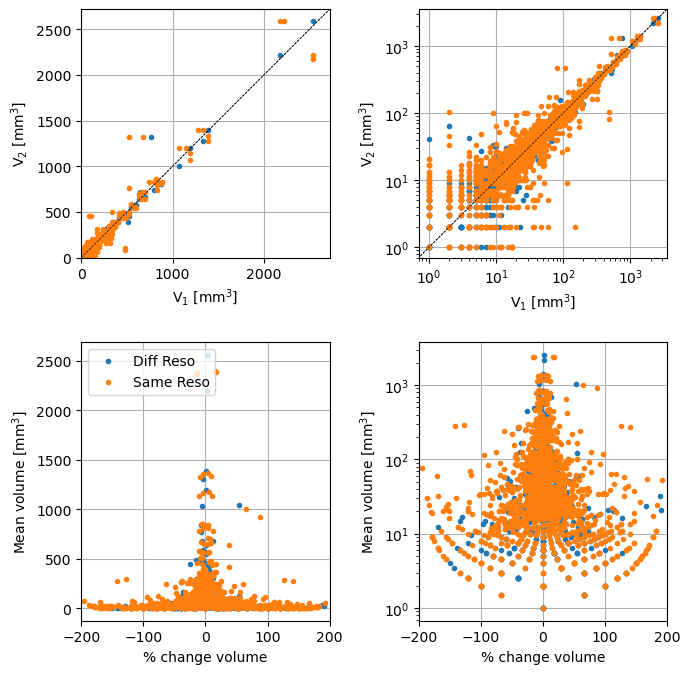

In [44]:
h = plot_v1v2_dvpdv(df.vol1,df.vol2,df.samereso)
h['h3'].legend(('Diff Reso','Same Reso'))




### Corro graficos viejo, en el .py

10 80.1259 (566) 40.4661 (1820)
20 72.8242 (936) 33.8796 (1450)
30 67.8142 (1202) 30.5447 (1184)
40 65.2193 (1386) 27.1490 (1000)
48 63.1543 (1509) 26.4366 (877)
50 62.7801 (1530) 26.5195 (856)
65 61.0702 (1680) 22.7354 (706)
100 57.7386 (1926) 21.5091 (460)
200 55.0259 (2151) 22.8265 (235)
300 54.0576 (2263) 14.0170 (123)
400 53.4810 (2313) 17.1740 (73)
500 53.3442 (2326) 17.4756 (60)
1000 52.9367 (2367) 14.8799 (19)
el desvío de los residuos es 7.98978
valor de la exonencial en 3tau es 5.20112


C:\Users\Diego\AppData\Local\Temp\ipykernel_19648\2468678895.py:50: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


Ecuación de la recta 1: V_2C = 30 + V1 * 1.95872
Ecuación de la recta 2: V_2C = V1 * 2.36412
val1 = 0.0239214% 
val2 = 9.86588e-08%


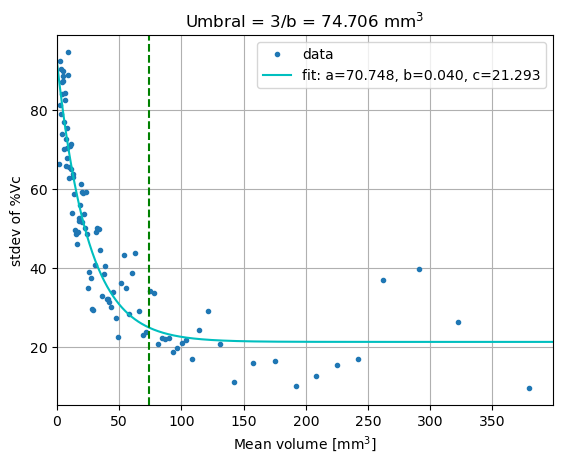

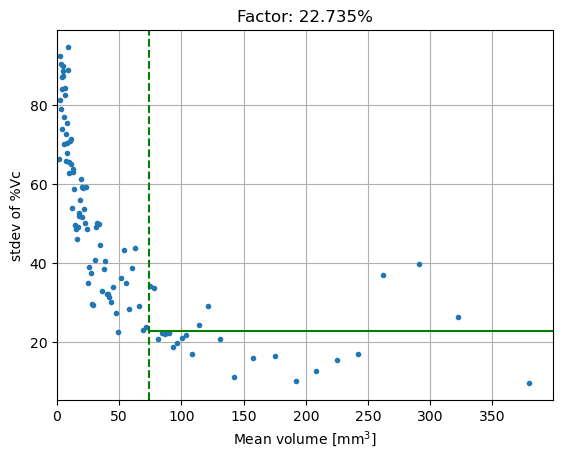

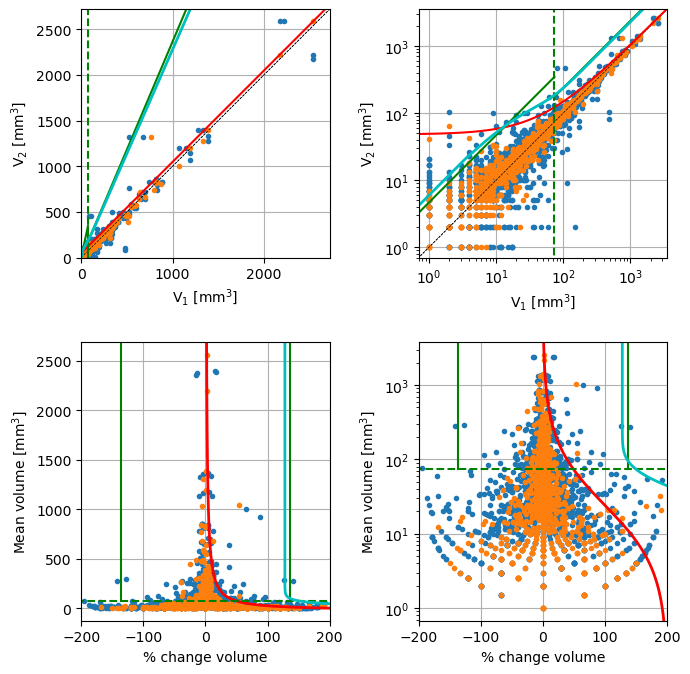

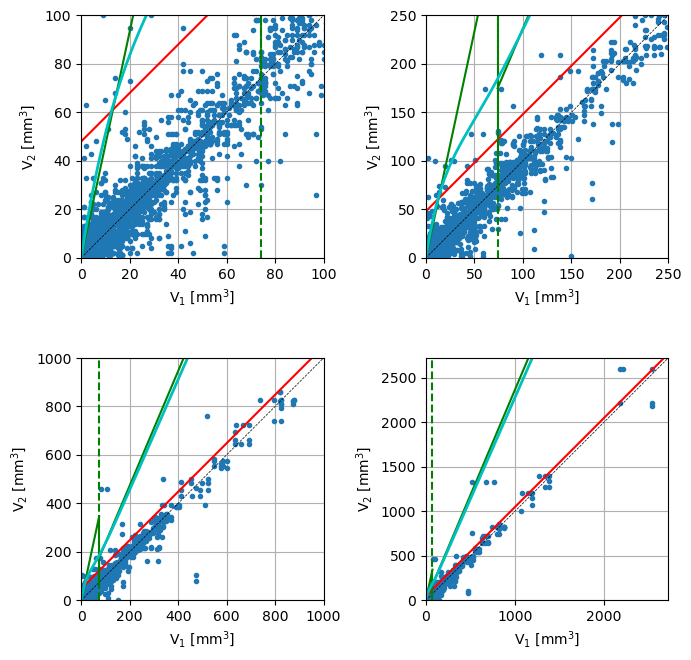

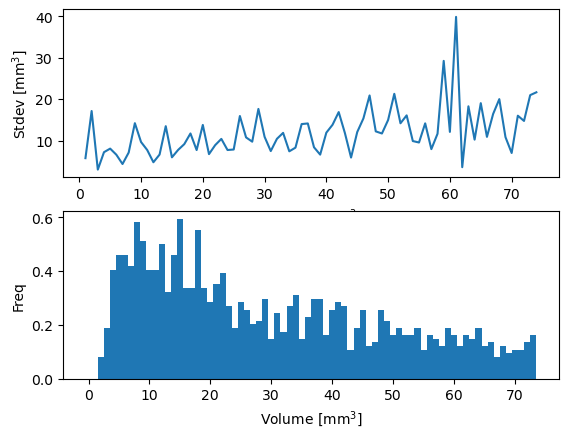

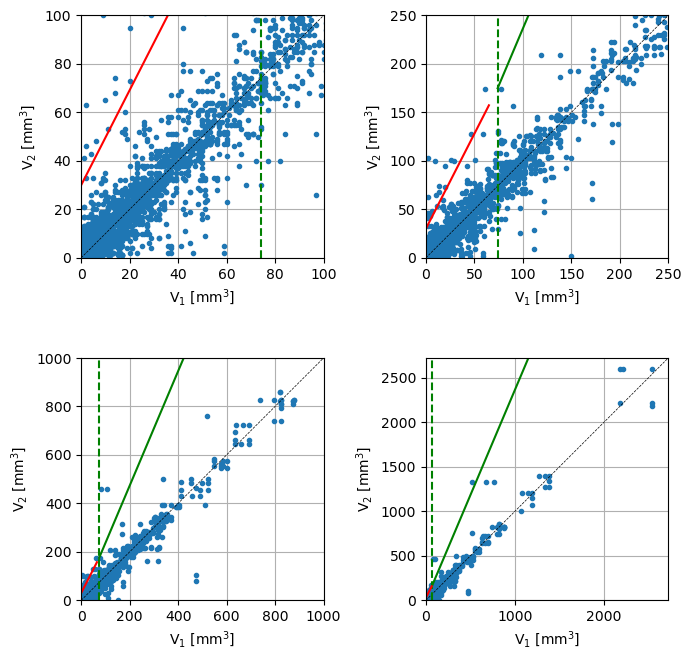

In [14]:
# %% exponencial stdev of %Vc vs mean volume

loaded = np.load(os.path.join(datadir,'PARES_6x4.npz'), allow_pickle=True)
loaded.files
PAR = list(loaded['PAR'])

nstd = 2.32634
nstd = 3
nstd = 6

samereso = [True]
samereso = [False]
# samereso = [True, False]

df = df_extract_vp_dvp(PAR,samereso)
vp, dvp, vol1, vol2 = df['vp'],df['dvp'],df['vol1'],df['vol2']
samereso = df['samereso']

###########################################
### Armo tabla sd(%Vc) small/large

tabla=[]
for umbral in [10,20,30,40,48,50,65,100,200,300,400,500,1000]:
    # umbral = 50
    data1 = [val[1] for val in zip(vp,dvp) if val[0]<=umbral]
    sd1 = np.std(data1)
    data2 = [val[1] for val in zip(vp,dvp) if val[0]>umbral]
    sd2 = np.std(data2)    
    print("%d %2.4f (%d) %2.4f (%d)"%(umbral,sd1,len(data1),sd2,len(data2)))
    tabla.append({'thres':umbral,'sd1':sd1,'n1':len(data1),'sd2':sd2,'n2':len(data2)})

umbral = 65
tablaumbral = [item for item in tabla if item['thres']==umbral ][0]

##########  Ajuste exponencial STD de %VC to mean volume
plt.figure(100)
ventana = 50
nventanas = 100
x=np.zeros(nventanas)
x[:] = np.nan
y=np.zeros(nventanas)
x[:] = np.nan
for i in range(nventanas):
    desde = int(i*np.floor((len(vp)-ventana)/nventanas))
    hasta = desde + ventana        
    x[i] = np.mean(vp[desde:hasta])
    y[i] = np.std(dvp[desde:hasta])
    
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

maxx = max(x)*1.05 
plt.plot(x,y,'.',label='data')    
popt, pcov = curve_fit(func, x, y)
# plt.plot(x,y-func(x, *popt),'.',label='Residuos')
print("el desvío de los residuos es %g" % np.std(y-func(x, *popt)))
print("valor de la exonencial en 3tau es %g" % (float(func(65, *popt))-float(popt[2])))

p_sigma = np.sqrt(np.diag(pcov))
x = np.linspace(0,maxx,1000)
plt.plot(x, func(x, *popt), 'c-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.legend()
plt.xlabel('Mean volume [mm$^3$]')
plt.ylabel('stdev of %Vc')
plt.grid(True)
plt.xlim([0 ,maxx])
plt.title('Umbral = 3/b = %2.3f mm$^3$' %  (3/popt[1]))
umbral = np.floor(3/popt[1])
myylim = plt.ylim()
plt.plot([umbral, umbral],myylim,'--g')
plt.ylim(myylim)

plt.figure(101)
ventana = 50
nventanas = 100
x=np.zeros(nventanas)
x[:] = np.nan
y=np.zeros(nventanas)
x[:] = np.nan
for i in range(nventanas):
    desde = int(i*np.floor((len(vp)-ventana)/nventanas))
    hasta = desde + ventana        
    x[i] = np.mean(vp[desde:hasta])
    y[i] = np.std(dvp[desde:hasta])
    
maxx = max(x)*1.05 
plt.plot(x,y,'.',label='data')    
x = np.linspace(0,maxx,1000)



sd1 = tablaumbral['sd1']
# plt.plot([0,umbral],[sd1, sd1],'g')
sd2 = tablaumbral['sd2']
plt.plot([umbral,maxx],[sd2,sd2],'g')
ylim = plt.ylim()
plt.plot([umbral,umbral],plt.ylim(),'--g')
plt.ylim(ylim) 

plt.xlabel('Mean volume [mm$^3$]')
plt.ylabel('stdev of %Vc')
plt.grid(True)
plt.xlim([0 ,maxx])
plt.title('Factor: %2.3f%%'%(sd2))
#####################################


        
        
h = plot_v1v2_dvpdv(vol1,vol2,samereso)
AgregoCte(['h1','h2'],['h3','h4'])
Agrego2sdSmallLarge(['h1','h2'],['h3','h4'],umbral, tablaumbral['sd1'],tablaumbral['sd2'])
Agrego2sdExpFit(['h1','h2'],['h3','h4'],popt) 

h = plot_v1v2_4escalas(vol1,vol2)
AgregoCte(['h1','h2','h3','h4'],[])
Agrego2sdSmallLarge(['h1','h2','h3','h4'],[],umbral, tablaumbral['sd1'],tablaumbral['sd2'])
Agrego2sdExpFit(['h1','h2','h3','h4'],[],popt) 



mysd = np.zeros(int(umbral))
vol1=np.array(vol1)
vol2=np.array(vol2)
for i in range(1,int(umbral)+1):
    data = np.concatenate((vol2[vol1==i], vol1[vol2==i]))
    mysd[i-1] = np.std(data) 

plt.figure(4)
plt.subplot(2,1,1)
x = np.linspace(1,int(umbral),int(umbral))
plt.plot(x,mysd)
plt.ylabel('Stdev [mm$^3$]')
plt.xlabel('Volume [mm$^3$]')

plt.subplot(2,1,2)
h = plt.hist(vol1+vol2,range(0,1+int(umbral)))
plt.cla()
plt.bar(h[1][:-1],h[0]/len(h[0]),width=1)
plt.xlabel('Volume [mm$^3$]')
plt.ylabel('Freq')

peso = h[0]/sum(h[0])

pend_arr = (1+nstd*tablaumbral['sd2']/100)

oo = umbral*pend_arr - umbral
# La oo la obtengo moviendo el valor para el nstd correspondiente, hasta obtener que val1 == val2
if nstd == 4:
    oo = 25.365 
elif nstd == 3:
    oo = 19 
else:
    oo = 30
    
U1 = umbral
U2 = umbral*(1+nstd*tablaumbral['sd2']/100)
pend = (U2-oo)/umbral

recta = oo+pend*x
fraccarr = (1-norm.cdf(recta,x,np.mean(mysd)))
value1 = sum(peso * fraccarr)
value2 = 1-norm.cdf(nstd)

h = plot_v1v2_4escalas(vol1,vol2)
Agrego2sdSmallLarge(['h1','h2','h3','h4'],[],umbral, np.nan,tablaumbral['sd2'])
AgregoRecta(['h1','h2','h3','h4'],[],oo,pend)


print('Ecuación de la recta 1: V_2C = %g + V1 * %g'%(oo,pend))
print('Ecuación de la recta 2: V_2C = V1 * %g'%(pend_arr))
print('val1 = %g%% \nval2 = %g%%'%(value1*100,value2*100))


# Paso a paso

In [32]:
# %% exponencial stdev of %Vc vs mean volume

loaded = np.load(os.path.join(datadir,'PARES_6x4.npz'), allow_pickle=True)
loaded.files
PAR = list(loaded['PAR'])

nstd = 2.32634
nstd = 3
nstd = 6

samereso = [True]
samereso = [False]
# samereso = [True, False]

df = df_extract_vp_dvp(PAR,samereso)
vp, dvp, vol1, vol2 = df['vp'],df['dvp'],df['vol1'],df['vol2']
samereso = df['samereso']
df

,vol1,vol2,sid,samereso,vp,dvp
1449,1.0,1.0,GAM,1.0,1.0,0.0
2696,1.0,1.0,VVS,0.0,1.0,0.0
66,1.0,1.0,CIM,1.0,1.0,0.0
2830,1.0,1.0,VVS,1.0,1.0,0.0
2832,1.0,1.0,VVS,1.0,1.0,0.0
...,...,...,...,...,...,...
764,2536.0,2178.0,FRO,0.0,2357.0,-15.188799
891,2536.0,2215.0,FRO,0.0,2375.5,-13.512945
1235,2178.0,2591.0,FRO,0.0,2384.5,17.320193
1347,2215.0,2591.0,FRO,0.0,2403.0,15.647108


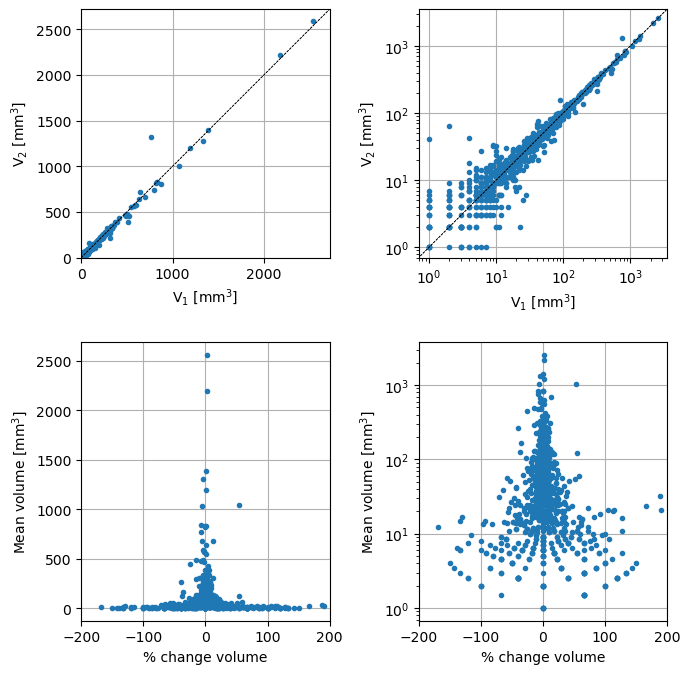

In [45]:
df_plot = df.query('samereso==1').copy()
h = plot_v1v2_dvpdv(df_plot['vol1'],df_plot['vol2'],df_plot['samereso'])

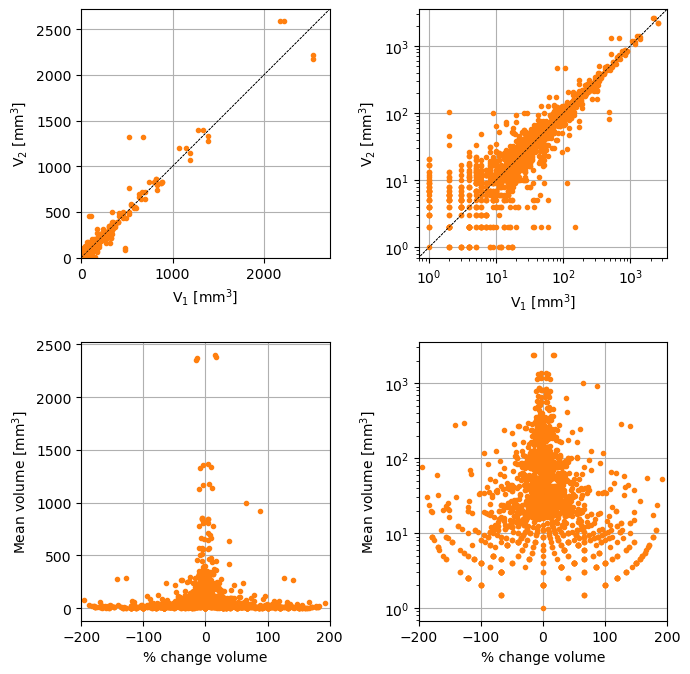

In [46]:
df_plot = df.query('samereso==0').copy()
h = plot_v1v2_dvpdv(df_plot['vol1'],df_plot['vol2'],df_plot['samereso'])

In [71]:


###########################################
### Armo tabla sd(%Vc) small/large

tabla=[]
for umbral in [10,20,30,40,48,50,65,100,200,300,400,500,1000]:
    # umbral = 50
    data1 = [val[1] for val in zip(vp,dvp) if val[0]<=umbral]
    sd1 = np.std(data1)
    data2 = [val[1] for val in zip(vp,dvp) if val[0]>umbral]
    sd2 = np.std(data2)    
    print("%d %2.4f (%d) %2.4f (%d)"%(umbral,sd1,len(data1),sd2,len(data2)))
    tabla.append({'thres':umbral,'sd1':sd1,'n1':len(data1),'sd2':sd2,'n2':len(data2)})

umbral = 65
tablaumbral = [item for item in tabla if item['thres']==umbral ][0]
tablaumbral


10 80.1259 (566) 40.4661 (1820)
20 72.8242 (936) 33.8796 (1450)
30 67.8142 (1202) 30.5447 (1184)
40 65.2193 (1386) 27.1490 (1000)
48 63.1543 (1509) 26.4366 (877)
50 62.7801 (1530) 26.5195 (856)
65 61.0702 (1680) 22.7354 (706)
100 57.7386 (1926) 21.5091 (460)
200 55.0259 (2151) 22.8265 (235)
300 54.0576 (2263) 14.0170 (123)
400 53.4810 (2313) 17.1740 (73)
500 53.3442 (2326) 17.4756 (60)
1000 52.9367 (2367) 14.8799 (19)


{'thres': 65,
 'sd1': 61.07019320777039,
 'n1': 1680,
 'sd2': 22.735351966683435,
 'n2': 706}

In [36]:
pd.DataFrame(tabla)

,thres,sd1,n1,sd2,n2
0,10,80.125851,566,40.466073,1820
1,20,72.824184,936,33.879564,1450
2,30,67.814176,1202,30.544673,1184
3,40,65.219269,1386,27.148999,1000
4,48,63.154269,1509,26.436586,877
5,50,62.780083,1530,26.519527,856
6,65,61.070193,1680,22.735352,706
7,100,57.738556,1926,21.509066,460
8,200,55.025934,2151,22.826522,235
9,300,54.057575,2263,14.017040,123


[7.07476375e+01 4.01576315e-02 2.12928044e+01]
el desvío de los residuos es 7.98978
valor de la exonencial en 3tau es 5.20112


C:\Users\Diego\AppData\Local\Temp\ipykernel_19648\514502574.py:16: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


(0.0, 130.0)

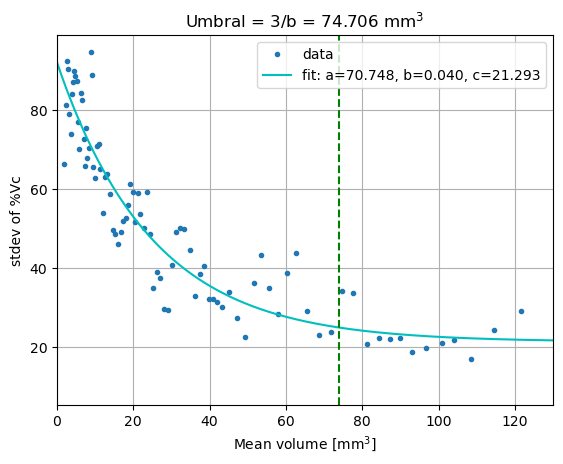

In [72]:
##########  Ajuste exponencial STD de %VC to mean volume
plt.figure(100)
ventana = 50
nventanas = 100
x=np.zeros(nventanas)
x[:] = np.nan
y=np.zeros(nventanas)
x[:] = np.nan
for i in range(nventanas):
    desde = int(i*np.floor((len(vp)-ventana)/nventanas))
    hasta = desde + ventana        
    x[i] = np.mean(vp[desde:hasta])
    y[i] = np.std(dvp[desde:hasta])
    
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

maxx = max(x)*1.05 
plt.plot(x,y,'.',label='data')    
popt, pcov = curve_fit(func, x, y)
print(popt)
# plt.plot(x,y-func(x, *popt),'.',label='Residuos')
print("el desvío de los residuos es %g" % np.std(y-func(x, *popt)))
print("valor de la exonencial en 3tau es %g" % (float(func(65, *popt))-float(popt[2])))

p_sigma = np.sqrt(np.diag(pcov))
x = np.linspace(0,maxx,1000)
plt.plot(x, func(x, *popt), 'c-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.legend()
plt.xlabel('Mean volume [mm$^3$]')
plt.ylabel('stdev of %Vc')
plt.grid(True)
plt.xlim([0 ,maxx])
plt.title('Umbral = 3/b = %2.3f mm$^3$' %  (3/popt[1]))
umbral = np.floor(3/popt[1])
myylim = plt.ylim()
plt.plot([umbral, umbral],myylim,'--g')
plt.ylim(myylim)
plt.xlim([0,130])

(0.0, 130.0)

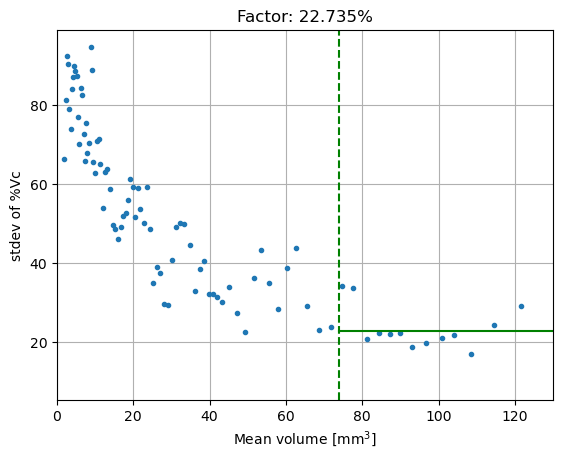

In [50]:

plt.figure(101)
ventana = 50
nventanas = 100
x=np.zeros(nventanas)
x[:] = np.nan
y=np.zeros(nventanas)
x[:] = np.nan
for i in range(nventanas):
    desde = int(i*np.floor((len(vp)-ventana)/nventanas))
    hasta = desde + ventana        
    x[i] = np.mean(vp[desde:hasta])
    y[i] = np.std(dvp[desde:hasta])
    
maxx = max(x)*1.05 
plt.plot(x,y,'.',label='data')    
x = np.linspace(0,maxx,1000)



sd1 = tablaumbral['sd1']
# plt.plot([0,umbral],[sd1, sd1],'g')
sd2 = tablaumbral['sd2']
plt.plot([umbral,maxx],[sd2,sd2],'g')
ylim = plt.ylim()
plt.plot([umbral,umbral],plt.ylim(),'--g')
plt.ylim(ylim) 

plt.xlabel('Mean volume [mm$^3$]')
plt.ylabel('stdev of %Vc')
plt.grid(True)
plt.xlim([0 ,maxx])
plt.title('Factor: %2.3f%%'%(sd2))
#####################################
plt.xlim([0,130])


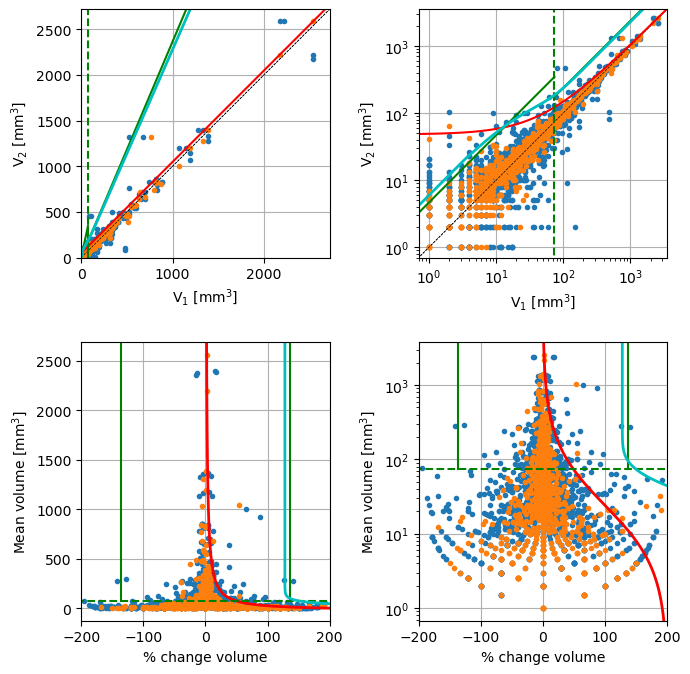

In [26]:
h = plot_v1v2_dvpdv(vol1,vol2,samereso)
AgregoCte(['h1','h2'],['h3','h4'])
Agrego2sdSmallLarge(['h1','h2'],['h3','h4'],umbral, tablaumbral['sd1'],tablaumbral['sd2'])
Agrego2sdExpFit(['h1','h2'],['h3','h4'],popt) 


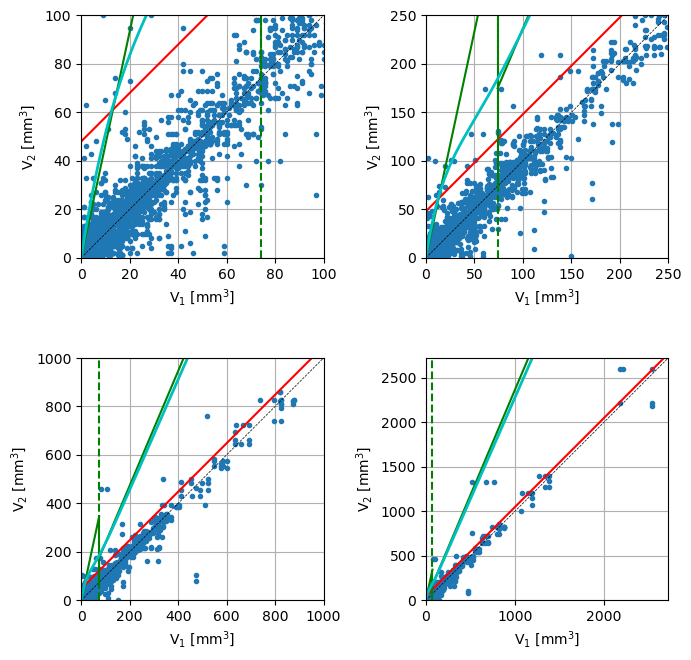

In [27]:
h = plot_v1v2_4escalas(vol1,vol2)
AgregoCte(['h1','h2','h3','h4'],[])
Agrego2sdSmallLarge(['h1','h2','h3','h4'],[],umbral, tablaumbral['sd1'],tablaumbral['sd2'])
Agrego2sdExpFit(['h1','h2','h3','h4'],[],popt) 


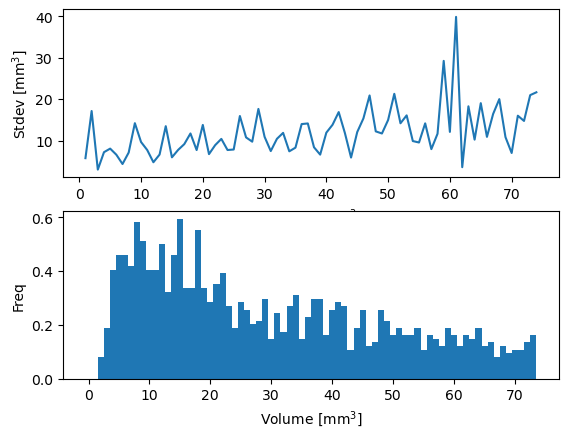

In [30]:

mysd = np.zeros(int(umbral))
vol1=np.array(vol1)
vol2=np.array(vol2)
for i in range(1,int(umbral)+1):
    data = np.concatenate((vol2[vol1==i], vol1[vol2==i]))
    mysd[i-1] = np.std(data) 

plt.figure(4)
plt.subplot(2,1,1)
x = np.linspace(1,int(umbral),int(umbral))
plt.plot(x,mysd)
plt.ylabel('Stdev [mm$^3$]')
plt.xlabel('Volume [mm$^3$]')

plt.subplot(2,1,2)
h = plt.hist(vol1+vol2,range(0,1+int(umbral)))
plt.cla()
plt.bar(h[1][:-1],h[0]/len(h[0]),width=1)
plt.xlabel('Volume [mm$^3$]')
plt.ylabel('Freq')

peso = h[0]/sum(h[0])

pend_arr = (1+nstd*tablaumbral['sd2']/100)

oo = umbral*pend_arr - umbral
# La oo la obtengo moviendo el valor para el nstd correspondiente, hasta obtener que val1 == val2
if nstd == 4:
    oo = 25.365 
elif nstd == 3:
    oo = 19 
else:
    oo = 30
    
U1 = umbral
U2 = umbral*(1+nstd*tablaumbral['sd2']/100)
pend = (U2-oo)/umbral

recta = oo+pend*x
fraccarr = (1-norm.cdf(recta,x,np.mean(mysd)))
value1 = sum(peso * fraccarr)
value2 = 1-norm.cdf(nstd)


Ecuación de la recta 1: V_2C = 30 + V1 * 1.95872
Ecuación de la recta 2: V_2C = V1 * 2.36412
val1 = 0.0239214% 
val2 = 9.86588e-08%


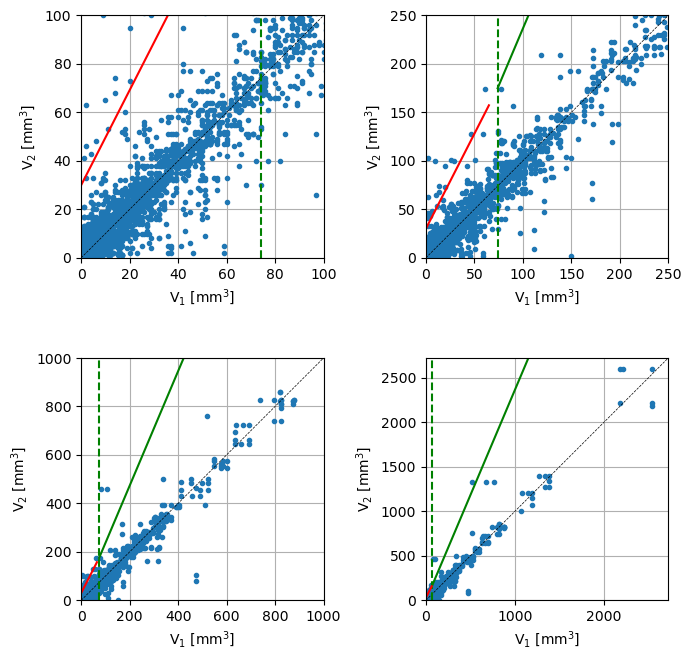

In [29]:

h = plot_v1v2_4escalas(vol1,vol2)
Agrego2sdSmallLarge(['h1','h2','h3','h4'],[],umbral, np.nan,tablaumbral['sd2'])
AgregoRecta(['h1','h2','h3','h4'],[],oo,pend)


print('Ecuación de la recta 1: V_2C = %g + V1 * %g'%(oo,pend))
print('Ecuación de la recta 2: V_2C = V1 * %g'%(pend_arr))
print('val1 = %g%% \nval2 = %g%%'%(value1*100,value2*100))

# Pasado en limpio

In [51]:
# %% exponencial stdev of %Vc vs mean volume

loaded = np.load(os.path.join(datadir,'PARES_6x4.npz'), allow_pickle=True)
loaded.files
PAR = list(loaded['PAR'])

nstd = 2.32634
nstd = 3
nstd = 6

samereso = [True]
samereso = [False]
# samereso = [True, False]

df = df_extract_vp_dvp(PAR,samereso)
# vp, dvp, vol1, vol2 = df['vp'],df['dvp'],df['vol1'],df['vol2']
# samereso = df['samereso']
df

,vol1,vol2,sid,samereso,vp,dvp
1449,1.0,1.0,GAM,1.0,1.0,0.0
2696,1.0,1.0,VVS,0.0,1.0,0.0
66,1.0,1.0,CIM,1.0,1.0,0.0
2830,1.0,1.0,VVS,1.0,1.0,0.0
2832,1.0,1.0,VVS,1.0,1.0,0.0
...,...,...,...,...,...,...
764,2536.0,2178.0,FRO,0.0,2357.0,-15.188799
891,2536.0,2215.0,FRO,0.0,2375.5,-13.512945
1235,2178.0,2591.0,FRO,0.0,2384.5,17.320193
1347,2215.0,2591.0,FRO,0.0,2403.0,15.647108


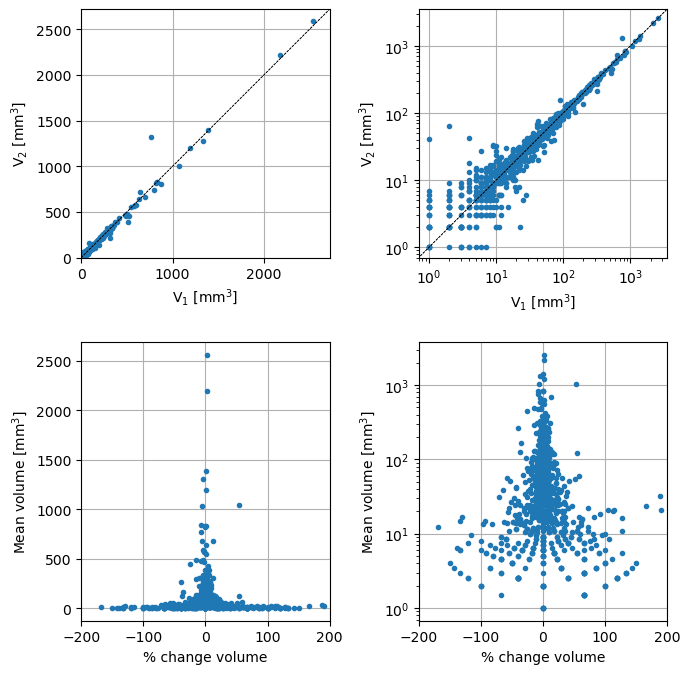

In [52]:
df_plot = df.query('samereso==1').copy()
h = plot_v1v2_dvpdv(df_plot['vol1'],df_plot['vol2'],df_plot['samereso'])

el desvío de los residuos es 5.25945
Amplitud: 68.39
Tau: 22.61
Offset: 9.73
valor de la exonencial en 3tau es 3.85743


Text(0, 0.5, 'stdev of %Vc')

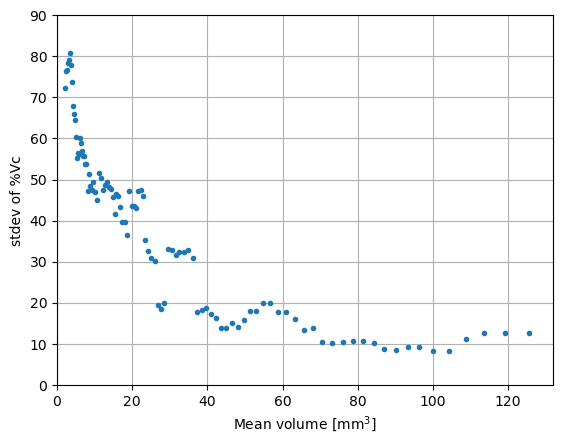

In [70]:
##########  Ajuste exponencial STD de %VC to mean volume
plt.figure(100)

def std_vs_mean(vp,dvp):
    ventana = 50
    nventanas = 100
    x=np.zeros(nventanas)
    x[:] = np.nan
    y=np.zeros(nventanas)
    x[:] = np.nan
    for i in range(nventanas):
        desde = int(i*np.floor((len(vp)-ventana)/nventanas))
        hasta = desde + ventana        
        x[i] = np.mean(vp[desde:hasta])
        y[i] = np.std(dvp[desde:hasta])
    return x,y

df_plot = df.query('samereso==1').copy()
x,y = std_vs_mean(df_plot.vp,df_plot.dvp)

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

maxx = max(x)*1.05 
plt.plot(x,y,'.',label='data')    
popt, pcov = curve_fit(func, x, y,p0=[80,0.04,10])
# plt.plot(x,y-func(x, *popt),'.',label='Residuos')
print("el desvío de los residuos es %g" % np.std(y-func(x, *popt)))
(func(65, *popt))-float(popt[2])
print(f'Amplitud: {popt[0]:.2f}')
print(f'Tau: {1/popt[1]:.2f}')
print(f'Offset: {popt[2]:.2f}')
print("valor de la exponencial en 3tau es %g" % (float(func(65, *popt))-float(popt[2])))
plt.grid(True)
plt.ylim([0,90])
maxx= max(x) * 1.05
plt.xlim([0 ,maxx])
plt.xlabel('Mean volume [mm$^3$]')
plt.ylabel('stdev of %Vc')

22.60719067827413